# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer. 

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Project Overview

**Offer Recommendation System**

- As Starbuck has offer porfolio, and we would like to recommend offers to different types of customers. In another perspective, we would like to know whether a customer who receive the offer will view offers. This is significant because from marketing perspective, the company would like to invest more resources into customers who are more likely to view offers, which in turn generate predictable sale leads. Therefore, in order to achieve this purpose, I would like to build a recommendation model to recommend the best offer to customers who would be more likely to respond to an offer (viewed offers). Offers do not necessarily need to be completed as our final target is to find out whether a customer will view our offers. After all, distributing an offer to a customer only general little business admin costs.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1.0 Exploratory Data Analysis

## 1.1 define plot functions

In [2]:
# countplot for category data
def count_category(df:pd.DataFrame, col:str):
    '''
    function that plots the count plot to examine the frequency categorical variables.
    args:
        df: dataframe that contains the categorical col we want to analyze
        col: categorical column on which countplot is graphed
    returns:
        None
    '''
    color = sns.color_palette()[0]
    count_order = df[col].value_counts(ascending = False).index
    sns.countplot(df[col],
                  color = color, 
                  order = count_order)
    plt.title(col)
    plt.show()

# histogram plot 
def hist_plot(df:pd.DataFrame, col:str, interval = 1):
    '''
    function that plots the histogram to examine the frequency numerical variables by number of. bins.
    args:
        df: dataframe that contains the numerical col we want to analyze
        col1: numerical column on which historgram is plotted
    returns:
        None
    '''
    bins = np.arange(df[col].min(), df[col].max(), interval)
    plt.hist(profile.age,bins = bins, alpha = 0.7)
    plt.axvline(df[col].mean(), color = 'red', linestyle = ':')
    plt.axvline(df[col].median(), color = 'green', linestyle = ':')
    plt.legend(loc='best')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('count')
    plt.show()

# scatterplot for the heatmap
def scatterplot_heatmap(df:pd.DataFrame, col1:str, col2:str):
    '''
    function that plots the heatmap to examine the frequency and correlation between two numerical variables.
    args:
        col1: numerical column one on which heatmap analysis is performed
        col2: numerical column two on which heatmap analysis is performed
    returns:
        None
    '''
    # data setup
    plt.hist2d(data = df, x = col1, 
               y = col2, 
               cmap = 'viridis_r', 
               cmin = 0.5)
    # show the color bar on the right to the axis
    plt.colorbar()
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()
    
# define the funciton for visualization
def cluster_analysis(col:str, condition = None):
    '''
    function that visualize cluster analysis to examine the conditional distribution
    args:
        col: column on which cluster analysis is performed
        condition: define on which conditions we want to apply on the column
    returns:
        None
    '''
    # extract list for those customers who churn
    churn_user_id = df.loc[df.respond == 1].userId.unique()

    if condition == None:
        # groupby userId and then compute how many sessions we have for each userId
        df_count = df.groupby('userId')[col].count().reset_index()
    else:
        df['condition'] = df[col].apply(lambda x: 1 if x in condition else 0)
        df_count = df.groupby('userId')['condition'].sum().reset_index()
    
    # insert churn_flag to the dataframe
    df_count['churn'] = df_count.userId.apply(lambda x: 1 if x in churn_user_id else 0)

    # remove null userId
    df_count = df_count[df_count.userId != '']

    # seperate customers who will churn or not into two seperate dataframe
    churn_cust = df_count[df_count.userId.isin(churn_user_id)]
    not_churn = df_count[~df_count.userId.isin(churn_user_id)]

    # plot the churn and not churn with different colors on the scatter plot
    if condition == None:
        plt.scatter(x = churn_cust.index, y = churn_cust[col], color = 'red')
        plt.scatter(x = not_churn.index, y = not_churn[col], color = 'blue')
        plt.xlabel('User')
        plt.ylabel(col)
        plt.legend(['Churn','Not Churn'])
        plt.show()
    else:
        plt.scatter(x = churn_cust.index, y = churn_cust['condition'], color = 'red')
        plt.scatter(x = not_churn.index, y = not_churn['condition'], color = 'blue')
        plt.xlabel('User')
        plt.ylabel(col+' = '+ ' '.join(condition))
        plt.legend(['Churn','Not Churn'])
        plt.show()

def plot_top10_freq(df:pd.DataFrame, col:str):
    '''
    function that visualize cluster analysis to examine the conditional distribution
    args:
        col: column on which 10 most frequent categories will be plotted
    returns:
        None
    '''

    # Return the Series having unique values
    base_color = sns.color_palette()[0]

    # Return the Series having frequency count of each unique value
    y = df[col].value_counts(sort = True).head(10)

    y.plot(kind = 'bar', color = base_color)

    # Labeling x and y axis
    plt.xlabel(col)
    plt.ylabel('count')
    plt.title('Ten Most Frequent Categoires on {}'.format(col))

    # Dsiplay the graph
    plt.show()


### General Statistics of Portfolio

In [3]:
# print out general statistics of portfolios
display(portfolio.head())
portfolio.describe()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [4]:
print(f'There are {portfolio.id.nunique()} offers in the portfolio')
print(f'There are {portfolio.offer_type.nunique()} offer types in the portfolio, they are {portfolio.offer_type.unique()}')

There are 10 offers in the portfolio
There are 3 offer types in the portfolio, they are ['bogo' 'informational' 'discount']


- Most of offers in the portfolio are difficult to achieve. offers (difficulty: 10) dominate our portfolio dataset.

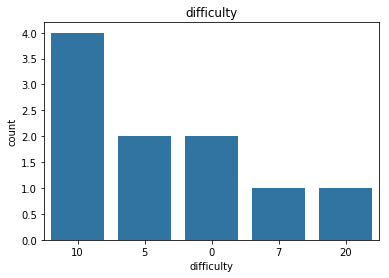

In [5]:
count_category(portfolio, "difficulty")

- most of offers are effective in 7 days after an offer was sent to clients

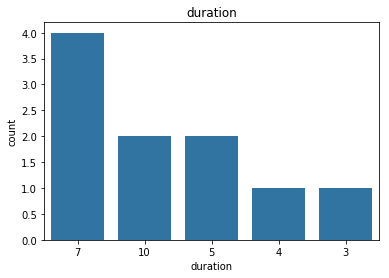

In [6]:
count_category(portfolio, "duration")

- The more dfficult offers, the longer the duration. This makes sense. Also, you can see that most offers with 10 of difficult typically valid with in 7 days after offer receipt.

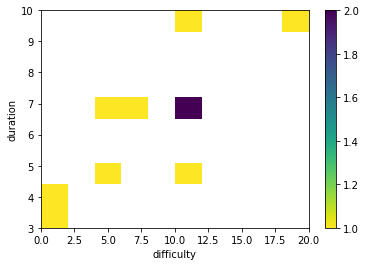

In [7]:
scatterplot_heatmap(portfolio, 'difficulty', 'duration')

- discount and bogo are the most frequent offers available to clients

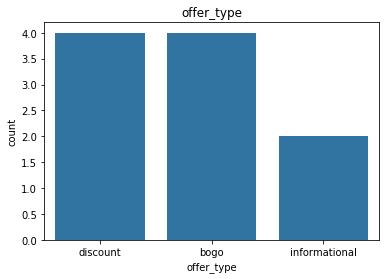

In [8]:
count_category(portfolio, "offer_type")

- However, as difficult offers are dominant in the portfolio, their rewards do not match up with their difficulty level...

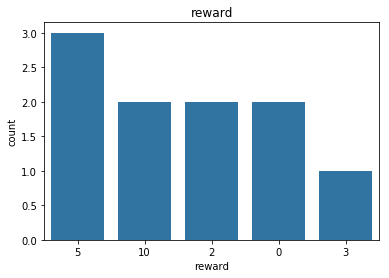

In [9]:
count_category(portfolio, "reward")

- As you can see, regarding offers with difficulty level at 10, their rewards do not quite match up. Offer have the same difficulty might not have the same rewards as you can see from the heatmap.

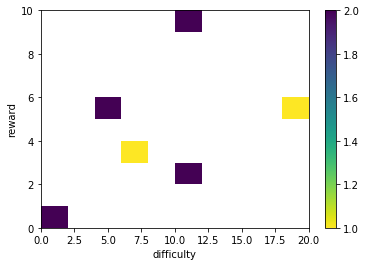

In [10]:
scatterplot_heatmap(portfolio, 'difficulty', 'reward')

- Most of offers are available through email, and the least for social

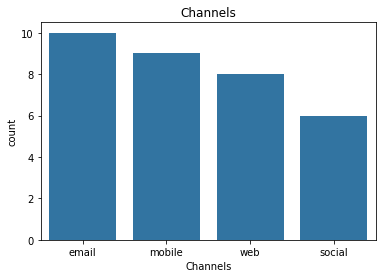

In [11]:
# before we plot the field - channel, we need to split and group channels into a list
channel = []
for i in portfolio['channels'].values:
    channel.extend(i)
channel = pd.DataFrame(channel)
channel.columns = ['Channels']
count_category(channel,'Channels')

### General Statistics of Profile

Most of clients are 60 - 80 years old, and some of clients are even 118. The mean of age is around 63 years old. The age distribution of clients are highly right skewed. Therefore, at this point, we probably need to cut off outliers from clients who are above 100 years old.

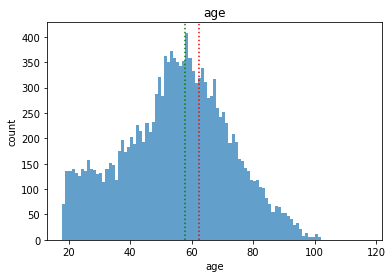

In [12]:
hist_plot(profile,'age',interval=1)

In our dataset, male clients take up the largest proportion in out simulated client profile.

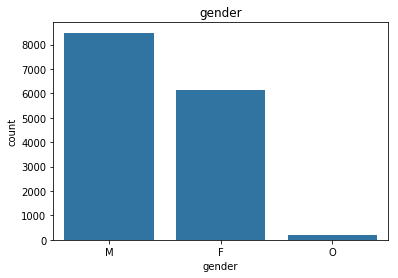

In [13]:
count_category(profile, 'gender')

### Number of Memebers Over Time

In [14]:
profile["became_member_on"] = pd.to_datetime(profile.became_member_on, format= '%Y%m%d')
year = profile.became_member_on.dt.year.astype(str) 
month = profile.became_member_on.dt.month.astype(str).apply(lambda x: '0'+x if len(x) == 1 else x)
profile["became_member_on_period"] = year + month
profile["became_member_on_period"] = profile["became_member_on_period"].astype(int)

I am not sure if the date does really matter but it seems that every July, the number of user will be twice as before
Then when it comes to the peak in 2017-12, it was off the high, and number of users was almost halved

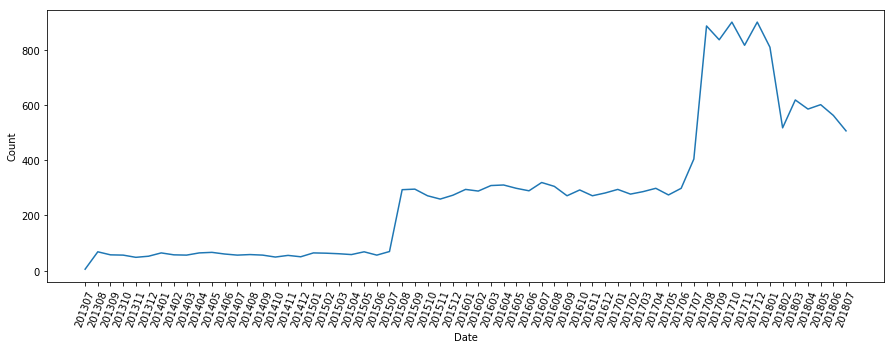

In [15]:
plt.figure(figsize = (15, 5))
year_idx = profile.groupby('became_member_on_period')['id'].count().index
value_idx = profile.groupby('became_member_on_period')['id'].count().values

plt.plot(year_idx.astype(str), value_idx)
plt.xticks(rotation = 70);
plt.xlabel('Date')
plt.ylabel('Count');

Most of customers recieve around 5 offers

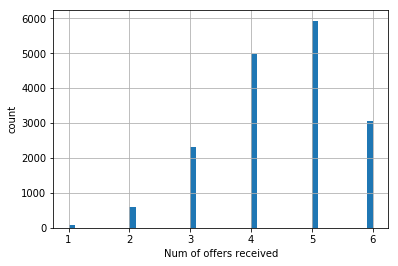

In [16]:
transcript.loc[transcript.event == 'offer received'].groupby('person').size().hist(bins = 50)
plt.xlabel('Num of offers received')
plt.ylabel('count');

However, most people just viewed 3 to 4 offers in general

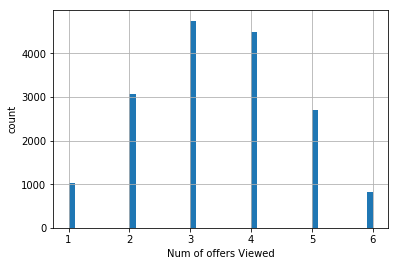

In [17]:
transcript.loc[transcript.event == 'offer viewed'].groupby('person').size().hist(bins = 50)
plt.xlabel('Num of offers Viewed')
plt.ylabel('count');

Certainly, lesser offers were completed 

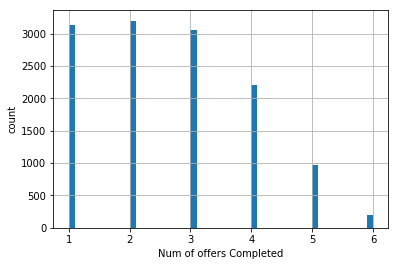

In [18]:
transcript.loc[transcript.event == 'offer completed'].groupby('person').size().hist(bins = 50)
plt.xlabel('Num of offers Completed')
plt.ylabel('count');

Most people spent $0 on any offers. However, some outliers do appear in our dataset (e.g, some people spent over \\$1100)

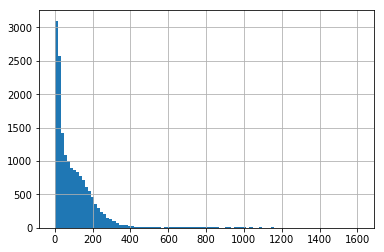

In [19]:
transcript['Amount'] = transcript[transcript.event == 'transaction'].value.apply(lambda x: x['amount'])
transcript.groupby('person')['Amount'].sum().hist(bins = 100);

In [20]:
# extract the offer id or amount from the field value
transcript['amount'] = transcript.value.apply(lambda x: x['amount'] if 'amount' in x.keys() else np.nan)
transcript['offer id'] = transcript.value.apply(lambda x: x['offer id'] if 'offer id' in x.keys() else np.nan)

On average, offers were recieved on day 13 since the start of the test, viewed on day 14 and completed on day 16

In [21]:
transcript.groupby('event')['time'].mean()/24

event
offer completed    16.710533
offer received     13.857480
offer viewed       14.762105
transaction        15.899347
Name: time, dtype: float64

We can see that in the field 'value', data is not consistent as we see multiple categories for the same item.

In [22]:
transcript['value'].apply(lambda x: x.keys()).value_counts()

(amount)              138952
(offer id)            134001
(offer_id, reward)     33578
(offer id)                 1
(offer_id, reward)         1
(amount)                   1
Name: value, dtype: int64

In [23]:
# define a custom functions
def offer_id(x):
    if 'offer id' in x.keys():
        return x['offer id']
    elif 'offer_id' in x.keys():
        return x['offer_id']
    else:
        return np.nan

transcript['offerId'] = transcript['value'].apply(lambda x: offer_id(x))

- Most people viewed their offers immeidately

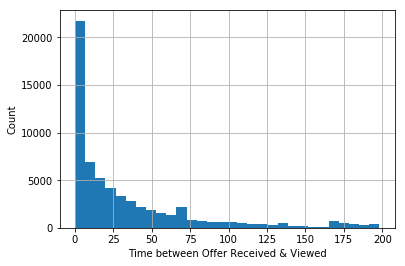

In [24]:
# get the base dataframe
# data cleaning
base = transcript[['person','offerId','event','time']]
base1 = base.loc[base.event == 'offer received']
base2 = base.loc[base.event == 'offer viewed']
base3 = base1.merge(base2, how='inner', on = ['person','offerId'])
base3['timebtwOfferReceivedViewed'] = base3['time_y'] - base3['time_x']

# remove negative values (negative valeus do not make sense, offer completed cannot occur prior to offer received)
base3 = base3.loc[(base3['timebtwOfferReceivedViewed'] >=0)&(base3['timebtwOfferReceivedViewed'] <= 200)]

# plot the histogram 
base3['timebtwOfferReceivedViewed'].hist(bins = 30)
plt.xlabel('Time between Offer Received & Viewed')
plt.ylabel('Count');

- Most pople completed offers right after they received offers (Some people may never view offers received)

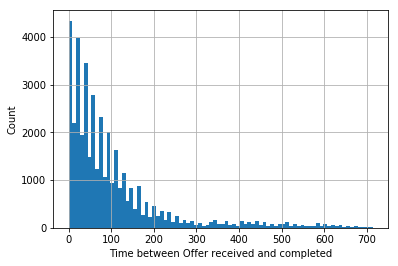

In [25]:
# data cleaning
base1 = base.loc[base.event == 'offer received']
base2 = base.loc[base.event == 'offer completed']
base3 = base1.merge(base2, how='inner', on = ['person','offerId'])
base3['timebtwOfferReceivedComp'] = base3['time_y'] - base3['time_x']

# remove negative values (negative valeus do not make sense, offer completed cannot occur prior to offer received)
base3 = base3[base3['timebtwOfferReceivedComp'] >=0]

# plot the histogram 
base3['timebtwOfferReceivedComp'].hist(bins = 80)
plt.xlabel('Time between Offer received and completed')
plt.ylabel('Count');

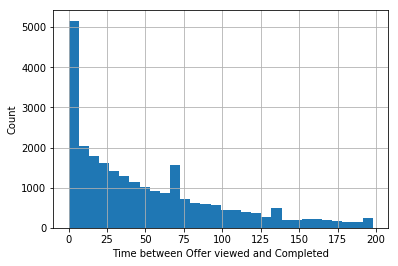

In [26]:
# data cleaning
base1 = base.loc[base.event == 'offer viewed']
base2 = base.loc[base.event == 'offer completed']
base3 = base1.merge(base2, how='inner', on = ['person','offerId'])
base3['timebtwOfferViewedComp'] = base3['time_y'] - base3['time_x']

# remove negative values (negative valeus do not make sense, offer completed cannot occur prior to offer received)
# remove outliers timelapse > 200
base3 = base3[(base3['timebtwOfferViewedComp'] >=0)&(base3['timebtwOfferViewedComp'] <=200)]

# plot the histogram 
base3['timebtwOfferViewedComp'].hist(bins = 30)
plt.xlabel('Time between Offer viewed and Completed')
plt.ylabel('Count');

- How many people did not view their offer but still completed

In [27]:
def rank_event(x):
    if x == 'offer completed':
        return 4
    elif x == 'offer received':
        return 1
    elif x == 'offer viewed':
        return 2

base['rank_event'] = base.event.apply(rank_event)

# get the base count dataframe for calculations
base_count = base.groupby(['person','offerId'])['rank_event'].sum().reset_index()

# there are around 3980 offers completed without actually viewing
q1 = base_count.query('rank_event == 5').shape[0]
print(f'there are around {q1} offers completed without actually viewing')

# there are around 18909 offers that have gone through the entire cycle
q2 = base_count.query('rank_event == 7').shape[0]
print(f'there are around {q2} offers that have gone through the entire cycle')

# there are around 20390 offers that have received and viewed but uncompleted
q3 = base_count.query('rank_event == 3').shape[0]
print(f'there are around {q3} offers that have received and viewed but uncompleted')

# there are around 8540 offers that just received only but not viewed by customers
q4 = base_count.query('rank_event == 1').shape[0]
print(f'there are around {q4} offers that that just received only but not viewed by customers')

# there are around 6245 offers assigned to the same person more than 1 time
q5 = base_count.query('rank_event > 7').shape[0]
print(f'there are around {q5} offers assigned to the same person more than 1 time')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


there are around 3980 offers completed without actually viewing
there are around 18909 offers that have gone through the entire cycle
there are around 20390 offers that have received and viewed but uncompleted
there are around 8540 offers that that just received only but not viewed by customers
there are around 6245 offers assigned to the same person more than 1 time


# 2.0 Clean up Missing Data and Variable Creation

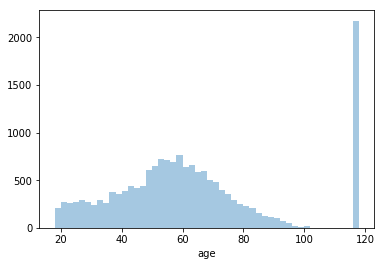

In [28]:
## we could there is a large spike in the age of 118. There are 
import seaborn as sns
sns.distplot(profile["age"], bins = 50, kde = False)
plt.show()

In [29]:
# customers who are 118 years old accounted for 12.79% of total population
profile.query('age == 118').id.nunique()/ profile.id.nunique()

## remove customer profile who were 118 years old and gender is None as this group of customers are outliers 
profile_clean = profile.loc[(profile.gender.notnull()) & (profile.age != 118)]

In [30]:
# convert member date to be how many days have passed since their member date
profile_clean['DaySinceMembers'] = (profile_clean['became_member_on'].max() - profile_clean['became_member_on']).dt.days
profile_clean['became_member_on'] = pd.to_datetime(profile_clean.became_member_on)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Profile - Table Cleaning and Variable Creation

In [31]:
# process gender column - one hot encoding gender column
df_gender = pd.get_dummies(profile_clean['gender'],prefix='gender')
profile_clean = profile_clean.drop(['gender'], axis =1)

# we can see that all of clients who did not report their gender also did not report their income
# therefore, we would use the entire income medium to fillna the missing values of income
profile_clean['income'] = profile_clean.income.fillna(profile.income.median())

# concat with main dataframe
profile_new = pd.concat([profile_clean,df_gender],axis =1)

In [32]:
profile_new.isnull().sum()

age                        0
became_member_on           0
id                         0
income                     0
became_member_on_period    0
DaySinceMembers            0
gender_F                   0
gender_M                   0
gender_O                   0
dtype: int64

## Transactions - Data Cleaning

In [33]:
# extract reward data when the event is completed (only offer completed will be granted a reward)
transcript['reward'] = transcript.value.apply(lambda x: x['reward'] if 'reward' in x.keys() else np.nan)

# get all necessary columns
transcript_new = transcript[['event','offerId','person','time','amount','reward']]

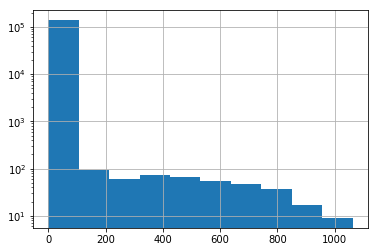

In [34]:
# Most of transaction amount is rather trivial or mnior. 
# But there are still a small number of transactions with amount exceeding $1,000 per transaction
transcript_new['amount'].hist(log=True)
plt.show()

In [35]:
# The number of non-transaction event should be the same as the number of null records in the column `amount`
# If return `True`, we dont need to deal with null values in the column `amount`
print((transcript_new.event != 'transaction').sum() == transcript_new.amount.isnull().sum())

# If null values in `offerId` is the same as transaction records, it is reasonable and we dont need to handle 
print((transcript_new.offerId.isnull()).sum() == (transcript_new.event == 'transaction').sum())

# if the number of offer completed is equal to the number of reward records, it is reasonable and we don't need to handle
print((transcript_new.event == 'offer completed').sum() == (transcript_new.reward.notnull()).sum())

True
True
True


## Portfolio - Data Cleaning

- As data in portfolio dataset is full and completed, we don't need to clean data in portfolio

In [36]:
portfolio['email_ok'] = portfolio.channels.apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile_ok'] = portfolio.channels.apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['web_ok'] = portfolio.channels.apply(lambda x: 1 if 'web' in x else 0)
portfolio['social_ok'] = portfolio.channels.apply(lambda x: 1 if 'social' in x else 0)
portfolio = portfolio.drop(['channels'],axis = 1)

In [37]:
# dummyify offer type and concat with the portfolio datasets
portfolio = pd.concat([portfolio,pd.get_dummies(portfolio.offer_type)], axis = 1)
portfolio = portfolio.drop(['offer_type'], axis = 1)

In [38]:
portfolio

,difficulty,duration,id,reward,email_ok,mobile_ok,web_ok,social_ok,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,0,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,1,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [39]:

temp = portfolio[['difficulty', 'duration', 'id', 'email_ok', 'mobile_ok','web_ok', 'social_ok', 'bogo', 'discount', 'informational']]
transcript_combined = transcript_new.merge(temp, how = 'left', left_on = 'offerId', right_on = 'id')
transcript_combined = transcript_combined.drop(['id'],axis = 1)

In [40]:
# we can combine the three datasets into one for variable creation
profile_new_combined = profile_new.merge(transcript_combined, how = 'left', left_on = 'id', right_on = 'person')

In [41]:
profile_new_combined = profile_new_combined.drop('id',axis =1)

## Data Analysis

### Time Series Analysis

- the purpose of doing cohort analysis is to examine whether a user's transaction amount would deteriorate along with the user's age profile (the longer he/she has become the member, the less amount he/she would spend)

In [42]:
# As you can see that the correlation between transaction amount and DaySinceMembers are slightly positive
# You can see that the relationship is not strong enough, only 0.166242

profile_new_combined[['DaySinceMembers', 'amount', 'person']]\
        .groupby('person').agg({'amount':'sum', 'DaySinceMembers':'max'})\
        .reset_index()[['amount','DaySinceMembers']].corr()

,amount,DaySinceMembers
amount,1.000000,0.166242
DaySinceMembers,0.166242,1.000000


- Let transform time from the unit of hour into the unit of days and see how it would impact transaction amount
- You can see that from the start of test, overall trend of transaction amount was increasing but had been through some ups and downs

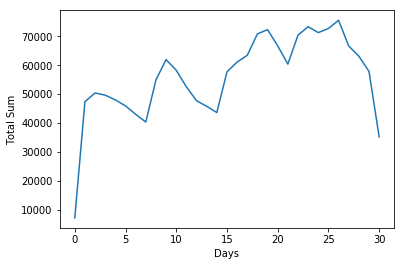

In [43]:
profile_new_combined['Days'] = (profile_new_combined.time/24).apply(math.ceil)
profile_new_combined.groupby('Days')['amount'].sum().plot()
plt.ylabel('Total Sum');


- You can see that from the start of test, overall the number of offer completed was increasing but had been through some ups and downs, which shared the same trend as that of transaction amount. Certainly, that make senses as transction amount is key indicator to how many offers completed.

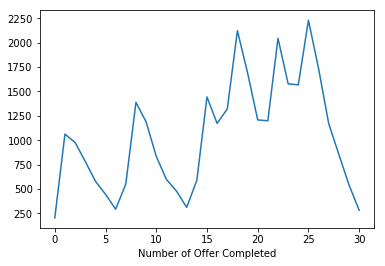

In [44]:
profile_new_combined['Completed_Flag'] = (profile_new_combined['event'] == 'offer completed').astype(int)
profile_new_combined.groupby('Days')['Completed_Flag'].sum().plot();
plt.xlabel('Number of Offer Completed');

### Offer Type Analysis


You can see that for informational offer they would not be `offer completed`. The reason is the `information` offer would not need to complete by user but just need to be viewed by users.

In [45]:
print((profile_new_combined[profile_new_combined.informational == 1]['event'] == 'offer completed').sum())
print((profile_new_combined[profile_new_combined.bogo == 1]['event'] == 'offer completed').sum())
print((profile_new_combined[profile_new_combined.discount == 1]['event'] == 'offer completed').sum())

0
15258
17186


In this case, we can see that column `information` might not be useful to predict whether the offer will be completed or not

In [46]:
person_offer = profile_new_combined[['person','offerId','event','time','duration','amount']]
person_offer['OfferReceivedFlag'] = person_offer.event.apply(lambda x: 1 if x == 'offer received' else np.nan)
person_offer['expiration'] = person_offer['OfferReceivedFlag']*24*person_offer['duration'] + person_offer['time']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Part I: Recommendation System

### <a class="anchor" id="User-User">User-Offer Matrix</a>

* Each **user** should only appear in each **row** once.

* Each **offer** should only show up in one **column**.  

* **If a user has interacted with an offer, then place a 1 where the user-row meets for that offer-column**.  It does not matter how much money a user has spent on the offer, all entries where a user has interacted with an offer should be a 1.  

* **If a user has not interacted with an offer, then place a zero where the user-row meets for that offer-column**. 

In [47]:
# seperate the data into tranasaction data and event data
event_data_temp = person_offer[person_offer.event != 'transaction']
transaction_data_temp = person_offer[person_offer.event == 'transaction']

# drop duplicated records
event_data_temp = event_data_temp.drop_duplicates()

# I want to make sure transaction and event data have no duplicated records
assert transaction_data_temp.drop_duplicates().shape[0] == transaction_data_temp.shape[0]
assert event_data_temp.drop_duplicates().shape[0] == event_data_temp.shape[0]

# use the offer expiration date to fill in other events with the same person id and offer id
event_data_temp['OfferExpiration'] = event_data_temp.groupby(['person','offerId'])['expiration']\
        .transform(lambda x: x.fillna(x.max()))

# select the subset of transaction data as we dont need all columns for merging two dataframes
event_data_temp2 = event_data_temp[['person','offerId','event','time','duration','OfferExpiration']]

# select the subset of transaction data as we dont need all columns for merging two dataframes
transaction_data_temp2 = transaction_data_temp[['person','time','amount']]

# merge two dataframes together
event_data_temp_transct = event_data_temp2.merge(transaction_data_temp2, left_on = 'person', right_on = 'person')

# filter records to ensure that transaction time falling between the offer received time and offer expiration time
event_data_temp_transct = event_data_temp_transct.query("(time_y >= time_x) & (time_y <= OfferExpiration)")

In [48]:
# event "offer viewed" is more important as it indicates whether there is correlation between offer and spending amount
# offer can be completed without actually viewing offers
# off received does not necessarily guarantee there is causation or correlation between offer and spending amount
# Therefore only 'offered viewed' can serve as a good indicator to prove the interaction between offers and customers

cust_offer_matrix = event_data_temp_transct.query('event == "offer viewed"')\
            .groupby(['person','offerId'])['amount'].sum().unstack().fillna(0)

# convert the customer-offer matrix into a binary matrix
cust_offer_matrix = (cust_offer_matrix > 0).astype(int)

### <a class="anchor" id="Rank">Rank-Based Recommendations</a>

* In our case, the most popular recommendations should based on the total amount spent on a particular offer. The more the amount spent on a given offer, the more popular the offer would be.

In [49]:
def get_top_offers(n, df):
    '''
    INPUT:
    n - (int) the number of top offers to return
    df - (pandas dataframe) df contain each offer viewd by customers and also the amount spent for that offer before offer expiration
    
    OUTPUT:
    top_offers - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_offers = df.groupby(['offerId']).sum().\
        sort_values(by = 'amount', ascending = False).\
        head(n).\
        reset_index()['offerId'].\
        tolist()

    return top_offers # Return the top offers from df 


get_top_offers(5, event_data_temp_transct.query('event == "offer viewed"'))

['fafdcd668e3743c1bb461111dcafc2a4',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 'f19421c1d4aa40978ebb69ca19b0e20d']

### <a class="anchor" id="Rank">User Offer Collaborative Filtering</a>

* To find out the similar users for our target user, we firstly sort by similarity scores. If there are more than one users who share the same similarity, we would look at amount spent by those similar customers and pick up the one with the highest spending amount in our dataset.

In [50]:
# create a similarity matrix: users by users
sim_matrix_master = pd.DataFrame(np.dot(cust_offer_matrix, cust_offer_matrix.T),
                    columns = cust_offer_matrix.index, 
                    index = cust_offer_matrix.index
)

# get the spending table for each users on the condition that they viewed their offers
spending_matrix = event_data_temp_transct.query('event == "offer viewed"').groupby(['person'])['amount'].sum()

In [51]:
def get_top_sorted_users(user_id, spending_matrix, sim_matrix_master):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    sim_matrix_master - (pandas dataframe) matrix of users by users who have interacted with the same offers: 
            the number represents how many same offers they have interacted to. The higher the number, the 
            more similar between this two users' behaivor.
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of offered interacted by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by amount spent where 
                    highest of each is higher in the dataframe
     
    '''
    
    # create a copy of sim_matrix_master to avoid overwrite 
    sim_matrix = sim_matrix_master.loc[user_id,:].to_frame()

    # ensure that the spending amount is driven by the offer, which is signified by offer viewed
    sim_matrix['spending'] = spending_matrix
    
    # reset the index and rename columns
    sim_matrix = sim_matrix.reset_index()
    sim_matrix.columns = ['neighbor_id', 'similarity', 'spending']

    # find the most similar users first, if there are more than two other users who share similar score
    # we return the one whose have more interactions with offers (more spending amount)
    neighbors_df = sim_matrix.sort_values(['similarity', 'spending'],ascending = [False, False])
    
    # remove the recomendation that recommend itself
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # return the dataframe specified in the doc_string
    return neighbors_df 

# testing
get_top_sorted_users(user_id='c894971c9e414a358b84255199727636',
                     spending_matrix = spending_matrix,
                     sim_matrix_master = sim_matrix_master).head(5)

,neighbor_id,similarity,spending
4211,4d4216b868fe43ddb9c9f0b77212c0cb,3,2455.95
3341,3d78362d314b43179af19945cfba03db,3,1586.71
11369,d1964a77dd594a59948acdfef291f2a3,3,1328.45
9352,ab25fd6fbd5040f880751921e4029757,3,1170.11
10979,ca3ed3e47a1e4ceea8dcd8b2bbaf1076,3,1082.82


In [52]:
# createa a master offer interaction dataset
master_offer_interactions = event_data_temp_transct.query('event == "offer viewed"')\
                                    .groupby('offerId')['person'].size()

def user_user_recs(user_id, m=3):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of offer recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by offer id
    
    Description:
    Loops through the customers based on closeness to the input person id
    For each user - finds offerId the user hasn't seen before and provides them as recs
    Does this until m number of recommendations are found
    
    Notes:
    * Choose the customers that have the most total amount spent
    before choosing those with less amount spent.

    '''
    rec = [] 

    neighbor_df = get_top_sorted_users(user_id,
                         spending_matrix,
                         sim_matrix_master)
    
    # get the list of offered that our target user has already interacted with
    target_offers = cust_offer_matrix.loc[user_id,:][cust_offer_matrix.loc[user_id,:] == 1].index.tolist()
    
    # if 10 offers have been distributed to such customers, we have no recommendations to them
    if len(target_offers) == 10:
        return None

    else:
        
        # As we dont know how much money customers will be spent for our offer recommendations 
        # as offers are unseen to customers
        # Therefore, at this point, it is safer to recommend offer that have most views by other customers
        
        # loop over each neighbor_id, starting from the most similar and also the most interactions with offers
        for neighbor_id in neighbor_df['neighbor_id']:

            # obtain the neighor's offers 
            neighbor_offers = cust_offer_matrix.loc[neighbor_id]\
                    [cust_offer_matrix.loc[neighbor_id,:] == 1].index.tolist()

            # obtain offers that target user has not seen before
            offer_not_seen = set(neighbor_offers) - set(target_offers)

            # if neighbor customers have less offer than target users, we pass
            if not offer_not_seen:
                continue
            
            else:
                # retrieve the recommended offers with the most interactions with users
                recom_offer_list = master_offer_interactions[list(offer_not_seen)].sort_values(ascending = False).index

                # exclude those recommendations that already exists
                rec.extend([offer for offer in recom_offer_list if offer not in rec])

                if len(rec) > m:
                    break
                else:
                    continue

    return rec[:m]

In [53]:
# testing
user_user_recs('621766e6e0c842e88f0ecb7741d4558a')

['fafdcd668e3743c1bb461111dcafc2a4',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '2298d6c36e964ae4a3e7e9706d1fb8c2']

## Part II: Forecasting whether a customer would view on our recommendations?


* However, as customers do not necessarily view our offer. Therefore, we also need to predict the probability that a customer will view our offer recommendation.
* First, we need to organize the data for training a model that can predict the probability of viewing our offers

* Second, we would create useful variables for training a model such that we can enable the model better capture the customer behaivor.

### Part 1. Data Manipulation

- The purpose is to get records for which offers were viewed by customers. Those records will be used as training dataset

- Also, we use `Offer Viewed` as our label data to train a model to predict which offers will be viewed by customers

In [54]:
# get all necessary column for building a classification mnodel
profile_new_temp = profile_new[['id','age', 'income', 'DaySinceMembers', 'gender_F', 'gender_M', 'gender_O']]

In [55]:
# remove transactions data first
data_viewed = person_offer[person_offer.event != 'transaction']

# create label data to indicate which clients views offers, which don't
data_viewed['Viewed'] = data_viewed.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

# through group by sum, we can get well-tabulated data for modeling
data_viewed = data_viewed.groupby(['person','offerId'])['Viewed'].sum().reset_index()

# some offers have distributed to customers for multiple times, therefore we need to truncate the number to 1
data_viewed['Viewed'] = data_viewed['Viewed'].apply(lambda x: 1 if x >= 1 else 0)

data_viewed = data_viewed.merge(portfolio, left_on = 'offerId', right_on = 'id', how = 'left').drop(['id'], axis = 1)

data_viewed = data_viewed.merge(profile_new_temp,left_on = 'person', right_on = 'id', how = 'left')\
                            .drop(['id'], axis = 1)

# set person as index
data_viewed = data_viewed.set_index('person')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Part 2. Variable Engineering

RFM (Recency, Frequency and Monetary) Model is a common technique used for analyzing customer behavior and also predict customer churn. The RFM Analysis will help the business to segment their customers into different homogenous groups so that they can engage with distinct group with more targeted marketing strategies.

- Recency: How recently did the customer visit our website or how recently did a customer purchase? (e.g., time since last visits or purchases)

- Frequency: How often do they visit or how often do they purchase? (e.g., the number of transactions/orders)

- Monetary:  How much do they spend when they purchase? (e.g., their total transaction amount)

In [56]:
# Recency - the average time lapse between two consecutive transactions for a given customers
# Get the user id from the cust_offer_matrix and only get the transaction records
subset_rfm = transcript[(transcript.event == 'transaction')]

# calculate the time lapse between two consecutive transaction within each group
subset_rfm['timesincelastpurchases'] = subset_rfm.groupby('person')['time'].diff().fillna(0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
# calculate the average time lapse since the last transaction
RFM_df = subset_rfm.groupby(['person'])['timesincelastpurchases'].mean().to_frame()

# calculate how many total transactions a given customer have in our dataset
RFM_df['Frequency'] = subset_rfm.groupby('person').size()

# calculate the average transaction amount
RFM_df['Monetary'] = subset_rfm.groupby(['person'])['amount'].mean()

# rename columns of dataframe for easier analysis
RFM_df.columns = ['AverageRecency', 'Frequency', 'Monetary']

# combine two variables into one variable - the average amount of each purchase for each customer
RFM_df['AverageMonetary'] = RFM_df['Monetary'] / RFM_df['Frequency']

In [58]:
# get the RFM variables and merge with the training dataset
RFM_df_training = RFM_df[['AverageRecency','Frequency','Monetary']]

# training dataset
training_data = data_viewed.merge(RFM_df_training, how = 'left', left_index= True, right_index= True)

In [59]:
# As you can see, there are over 1235 customers who have never spent any amount
# We will fill in the missing values with 0
print(training_data.isnull().sum())
training_data = training_data.fillna({'AverageRecency':0,'Frequency':0,'Monetary':0 })

offerId               0
Viewed                0
difficulty            0
duration              0
reward                0
email_ok              0
mobile_ok             0
web_ok                0
social_ok             0
bogo                  0
discount              0
informational         0
age                   0
income                0
DaySinceMembers       0
gender_F              0
gender_M              0
gender_O              0
AverageRecency     1235
Frequency          1235
Monetary           1235
dtype: int64


### Model Training - Offer Viewed

- The reason why I would use F1 score is that the score can be a better representation when the unbalanced class issue does exist in out dataset.

- Also, F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution.

In [60]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              RandomForestRegressor, GradientBoostingRegressor)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [61]:
# split the label and training dataset
label = training_data[['Viewed']]

train_data = training_data[['difficulty', 'duration', 'reward',
       'email_ok', 'mobile_ok', 'web_ok', 'social_ok', 'bogo', 'discount',
       'informational', 'age', 'income', 'DaySinceMembers', 'gender_F',
       'gender_M', 'gender_O', 'AverageRecency', 'Frequency', 'Monetary']]

In [62]:
# put all models into a list
model_selections = [LogisticRegression(),
                    DecisionTreeClassifier(),
                    RandomForestClassifier(),
                    GradientBoostingClassifier()]

# Using cross validation to find out which ML models fit the data best
performance = float('-inf')
model_idx = 0

for idx, model in enumerate(model_selections):
    scores = cross_val_score(estimator = model,
                    X = train_data,
                    y = label,
                    scoring = 'f1',
                    cv = 5
                   )
    print(f'model {idx+1}\'s F1-Score performance',np.mean(scores))

model 1's F1-Score performance 0.876192151393
model 2's F1-Score performance 0.860234922012
model 3's F1-Score performance 0.893535480622
model 4's F1-Score performance 0.905912296531


* We can see the the Gradient Boosting Classifier fits data the best. Therefore Gradient Boosting Classifier will be used to predict the probability of whether the offer recommended will be viewed

In [63]:
# instantiate the model 
GBT = GradientBoostingClassifier()

# get the f1 score for each cross validation set
scores = cross_val_score(estimator = GBT,
                    X = train_data,
                    y = label,
                    scoring = 'f1',
                    cv = 5
                   )

# print out the average score for the best model
print(np.mean(scores))

# train the model with all data
GBT_model = GBT.fit(X = train_data, 
                  y = label
                 )

0.905912296531


In [64]:
# Compare with the benchmark (over 70% offers were viewed). As our model cross validation score is way higher than the baseline 
# Therefore our model is an ideal option used to predict the probability of whether offer will be viewed
label['Viewed'].mean()

0.7694940422295462

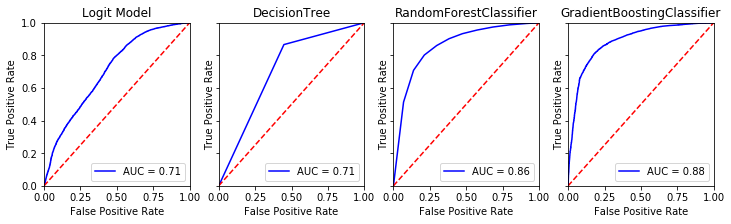

In [65]:
# We can also plot roc_auc curve to have better understanding about our options
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Make a figure for plotting
fig, ax = plt.subplots(1,4, figsize = (12, 3), sharex = True, sharey = True)

# put all models into a list
model_selections = [LogisticRegression(),
                    DecisionTreeClassifier(),
                    RandomForestClassifier(),
                    GradientBoostingClassifier()]

# Get the model name to put as title on the plot 
model_names = ['Logit Model', 'DecisionTree', 'RandomForestClassifier', 'GradientBoostingClassifier']

# Train test split
X_train, X_test, y_train, y_test =  train_test_split(train_data,label,test_size= 0.33)

# Calculate the fpr and tpr for all thresholds of the classification
def plot_roc_auc(model,X_test,y_test,ax, title):
    """
    function that plots the ROC_AUC to examine the accuracy of classification models.
    args:
        model: model that we traiend
        X_test: holdout data for make predictions
        y_test: test set against which will be compared
        ax: the axes on which the plot will be put
        title: the title we want to put on the plot
    returns:
        None
    
    """
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # plot ROC_ACU_Curve
    plt.title('Receiver Operating Characteristic')
    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(title)
    
# Looping over models
for idx, model in enumerate(model_selections):
    clf = model.fit(X_train, y_train)
    plot_roc_auc(clf,X_test,y_test,ax[idx],model_names[idx])

* You can see that more complicated model - GradientBoostingClassifier obviously does a better job in predicting offer viewed or not

### Fine-tune Model 

* Now, with the basic understanding about the best model, we can start to search the best parameters for our model by using GridSearchCV

In [66]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score

## Prepare a set of parameters to fine tune
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    "min_samples_split": np.linspace(0.1, 0.5, 10),
    "min_samples_leaf": np.linspace(0.1, 0.5, 10),
    "max_depth":[3,5,8,10,12],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10,30,50,70,90, 100]
    }

## Instantiate GridSearchCV object
clf = RandomizedSearchCV(GradientBoostingClassifier(), 
                   parameters,
                   scoring='f1',
                   cv=5, 
                   n_jobs=-1)


## Search the best parameter set for our classification model
best_classification_clf = clf.fit(train_data, label)

## Get the best_params and best_scores
best_params = best_classification_clf.best_params_
best_scores = best_classification_clf.best_score_

## Train the best model on the entire dataset for our deployment
best_classification_clf = GradientBoostingClassifier(**best_params).fit(train_data, label)

### Now we need to deploy model in the production and make recommendations

In [67]:
# fill in with 0 for the person records with misisng values as they dont have any transaction records in our dataset
df_profile = profile_new_temp.merge(RFM_df.reset_index(),how = 'left', left_on = 'id', right_on = 'person')\
                    .fillna({'AverageRecency':0,'Frequency':0,'Monetary':0, 'AverageMonetary':0})

In [68]:
# firstly cross join all offers and profile 
portfolio['key'] = 0 
df_profile['key'] = 0

# new we can user our model to predict the probability of viewing offers of all user-offer combinations
df_new_test = portfolio.merge(df_profile,on = 'key')

# get the data for training
X_new_test_ = df_new_test[train_data.columns]

df_new_test['prob_offer_view'] = best_classification_clf.predict_proba(X_new_test_)[:,1]

# extract all columns in need
prob_view_offer = df_new_test[['id_x', 'id_y', 'prob_offer_view']]

# rename the columns
prob_view_offer.columns = ['offerId', 'personId', 'prob_offer_view']

In [69]:
prob_view_offer.head()

,offerId,personId,prob_offer_view
0,ae264e3637204a6fb9bb56bc8210ddfd,0610b486422d4921ae7d2bf64640c50b,0.882648
1,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,0.885413
2,ae264e3637204a6fb9bb56bc8210ddfd,e2127556f4f64592b11af22de27a7932,0.888507
3,ae264e3637204a6fb9bb56bc8210ddfd,389bc3fa690240e798340f5a15918d5c,0.890097
4,ae264e3637204a6fb9bb56bc8210ddfd,2eeac8d8feae4a8cad5a6af0499a211d,0.869610


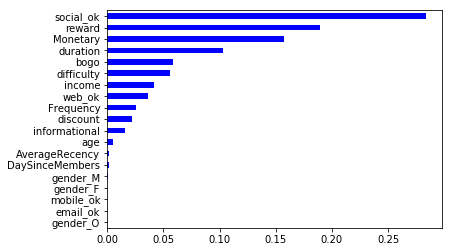

In [70]:
# display the importance of features
features_importance = pd.Series(best_classification_clf.feature_importances_)

features_importance.index = train_data.columns

# plot feature
features_importance.sort_values().plot(kind='barh', color = 'blue')

plt.show()

- We can see the whether an offer can be access through social platforms will be a key factor for whether an offer will be viewed by customers. That is reasonable as most people have their own social accounts and would spend at least some time on social platform.
- The other key factor is the past transaction amount. Customers' transaction amount can determine whether an offer will be viewed.

In [71]:
# initialize dictionary for storing results
recomendations = {}

len_personid = len(cust_offer_matrix.index)

# loop over all the PersonId (It would take very long to loop all person ID)
for idx, personid in enumerate(cust_offer_matrix.index):

    # print out progressing progress
    print(f'processing {idx+1}/{len_personid} customers')
    
    # get neighbor users with the top 3 choices of offers
    rec_list = user_user_recs(user_id = personid, m = 3)
    
    proba_list = []
    
    # loop over each rec
    for rec in rec_list:
        
        # get the probability that customer will view our recommendations
        prob = prob_view_offer.loc[(prob_view_offer.offerId == rec)&(prob_view_offer.personId == personid),'prob_offer_view'].values[0]
    
        # append the probabaility
        proba_list.append(prob)
 
    # create a temp dict for later sorting
    temp = dict(zip(rec_list,proba_list))
    
    # store the results
    recomendations[personid] = temp

processing 1/13831 customers
processing 2/13831 customers
processing 3/13831 customers
processing 4/13831 customers
processing 5/13831 customers
processing 6/13831 customers
processing 7/13831 customers
processing 8/13831 customers
processing 9/13831 customers
processing 10/13831 customers
processing 11/13831 customers
processing 12/13831 customers
processing 13/13831 customers
processing 14/13831 customers
processing 15/13831 customers
processing 16/13831 customers
processing 17/13831 customers
processing 18/13831 customers
processing 19/13831 customers
processing 20/13831 customers
processing 21/13831 customers
processing 22/13831 customers
processing 23/13831 customers
processing 24/13831 customers
processing 25/13831 customers
processing 26/13831 customers
processing 27/13831 customers
processing 28/13831 customers
processing 29/13831 customers
processing 30/13831 customers
processing 31/13831 customers
processing 32/13831 customers
processing 33/13831 customers
processing 34/13831

In [72]:
import pickle
# save it as pickle file
with open('recommendation.pickle', 'wb') as handle:
    pickle.dump(recomendations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [73]:
# load recommendation dictionary
import pickle
with open('recommendation.pickle', 'rb') as handle:
    recomendations = pickle.load(handle)

### General Study of Probability-based Recommendations

In [74]:
offer_stat = {}

for k, v in recomendations.items():
    for offer, prob in v.items():
        if offer not in offer_stat.keys():
            offer_stat[offer] = 1
        else: 
            offer_stat[offer] += 1
            
recom_outputs = pd.Series(offer_stat).sort_values(ascending = False)

# display the recommendation to show which offers were recommendeded the most in our dataset
display(recom_outputs)

# top options offers
top_option_offers = {}
top_offer_df = {}

# sort recommendations 
for k, v in recomendations.items():
    _new_dict_ = dict(sorted(v.items(), key = lambda item:item[1], reverse = True))
    
    top = list(_new_dict_.keys())[0]
    
    # extract the only top offer with the corresponding personId
    top_offer_df[k] = top
    
    if top not in top_option_offers.keys():
        top_option_offers[top] = 1
    else:
        top_option_offers[top] += 1

top_recom_outputs = pd.Series(top_option_offers).sort_values(ascending = False)

# display the recommendation to show which offers were recommendeded the most as top choice in our dataset
display(top_recom_outputs)

# get a top offer ranks for labeling (later use)
top_offer_ranks = dict(zip(top_recom_outputs.index, 
                           range(1,len(top_recom_outputs.index)+1)
                          )
                      )

fafdcd668e3743c1bb461111dcafc2a4    5999
2298d6c36e964ae4a3e7e9706d1fb8c2    5931
f19421c1d4aa40978ebb69ca19b0e20d    4595
2906b810c7d4411798c6938adc9daaa5    4577
4d5c57ea9a6940dd891ad53e9dbe8da0    4485
ae264e3637204a6fb9bb56bc8210ddfd    3872
0b1e1539f2cc45b7b9fa7c272da2e1d7    3758
9b98b8c7a33c4b65b9aebfe6a799e6d9    3191
3f207df678b143eea3cee63160fa8bed    2826
5a8bc65990b245e5a138643cd4eb9837    2259
dtype: int64

4d5c57ea9a6940dd891ad53e9dbe8da0    4485
ae264e3637204a6fb9bb56bc8210ddfd    2812
f19421c1d4aa40978ebb69ca19b0e20d    2768
2298d6c36e964ae4a3e7e9706d1fb8c2    2305
fafdcd668e3743c1bb461111dcafc2a4     552
5a8bc65990b245e5a138643cd4eb9837     438
2906b810c7d4411798c6938adc9daaa5     213
3f207df678b143eea3cee63160fa8bed     161
9b98b8c7a33c4b65b9aebfe6a799e6d9      97
dtype: int64

- As you can see, based on our recommendation system output, offerId - `fafdcd668e3743c1bb461111dcafc2a4` is recommended for around 6000 times

- However offerId - `4d5c57ea9a6940dd891ad53e9dbe8da0` was the top offer recommended by our recommendation system

### Take a Deep Dive into Recommendation Results

In [75]:
# map the offerID with the offer label for better analysis
portfolio['OfferLabel'] = portfolio['id'].map(top_offer_ranks)

In [76]:
top_offer_df_2 = pd.Series(top_offer_df).to_frame()

# rename the column
top_offer_df_2.columns = ['Top_Offer']

# merge with the customer profile data
top_offer_df_2 = top_offer_df_2.join(profile_new_temp.set_index('id'))

# merge with the RFM dataframe
RFM_df_final = top_offer_df_2.join(RFM_df)

# label the Top Offer to be Label ID according to the most top offer ranks
RFM_df_final['OfferLabel'] = RFM_df_final.Top_Offer.map(top_offer_ranks)

# generate the summary statistics of RFM
RFM_df_final_groupby = RFM_df_final.groupby('OfferLabel').agg(['mean','median','std'])

# merge with the offers' information to get their detailed information
RFM_df_final_groupby = RFM_df_final_groupby.\
        merge(portfolio.set_index('OfferLabel'), 
               how = 'left', 
               left_index = True, 
               right_index=True
)

In [77]:
# extract the columns we need for doing investigation
RFM_df_final_groupby[[('AverageRecency', 'mean'), ('Monetary', 'mean'),('Frequency', 'mean'),\
                       'reward','difficulty', 'duration','social_ok','discount','informational','bogo',
                      ('age', 'median'),('income', 'mean')
]]

,"(AverageRecency, mean)","(Monetary, mean)","(Frequency, mean)",reward,difficulty,duration,social_ok,discount,informational,bogo,"(age, median)","(income, mean)"
OfferLabel,,,,,,,,,,,,
1,71.359585,14.924053,8.352731,10,10,5,1,0,0,1,55.0,65651.727982
2,63.695257,14.875260,9.940967,10,10,7,1,0,0,1,55.0,62779.160740
3,71.005394,13.782308,8.327312,5,5,5,1,0,0,1,55.0,63694.002890
4,74.300652,18.312331,8.119740,3,7,7,1,1,0,0,57.0,69478.958785
5,69.467698,14.720817,9.099638,2,10,10,1,1,0,0,54.0,61106.884058
6,63.950260,15.332458,10.484018,0,0,3,1,0,1,0,55.5,65639.269406
7,63.087531,15.494269,10.399061,2,10,7,0,1,0,0,52.0,68356.807512
8,55.095461,14.339390,12.503106,0,0,4,0,0,1,0,53.0,60720.496894
9,68.777094,3.147162,8.536082,5,5,7,0,0,0,1,45.0,42453.608247


In [78]:
portfolio

,difficulty,duration,id,reward,email_ok,mobile_ok,web_ok,social_ok,bogo,discount,informational,key,OfferLabel
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,0,1,1,0,0,0,2.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0,0,1.0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1,0,8.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0,0,9.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,1,0,0,1,0,0,NaN
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0,0,4.0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0,0,5.0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,1,0,0,1,0,6.0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0,0,3.0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0,0,7.0


# Conclusion

**With the recommendation results, here are a few highlights of my findings:**

1. The recommendation system prefers recommending offers which can be accessed through social platforms. One plausible explanation is that offers that can be viewed through social platforms are more likely to be accessed by customers. As people are more likely to open Facebook, Instagram or Snapchat for a few times a day than Email, Website or Mobile Application.

2. Top offers are recommended to customers who have relatively long time lapse between two consecutive purchases, and also lower frequency of purchases, because these offers (e.g., Offer 1, 2 3 and 4) in general have larger rewards and BOGO (buy one get one free) that are more appealing than offers at the higiher rank.

3. To retain customers, our recommendation system has learned using BOGO (buy one get one free) or discount type offer to reactive customers. For customers who have more frequent purchases and larger transaction amount, informational offers will also be used.

4. The offer with the difficulty level at 20 was never recomended by our recommendation system. One feasible explanation is because this type of offer was seldomly viewed by customers in our dataset or the mismatch between difficulty and rewards really deters customers.

## Improvement

1. Our process of selecting models and fine-tuning their parameters are oversimplified. The best practice is to build up a parameter table to display different sets of their parameters with the model holdout results so as to have a clearer understanding about which set of parameters of different algorithms work the best to predict the probability.

2. RFM analysis actually is a rather naive analysis approach. It naively assumes that the historical customer behavior will be representative of their future cusotmer behavior, which is obviously not the case as customer behavior will be impacted by a multitiude of factors such as competing offers from other coffee chains, economic situations and so on. Therefore, to get a better analysis on customer behavior, beside incorporating customer preference, we need to define which stage of company lifecycle we are currently in (e.g., user acquisition, user retention or maintenance) and then define a specific metrics to evaluate customer behavior.

3. Our analysis missed one of the most important customer segments - Loyal Customers. Those customers would make big purchases from time to time, even without offers being distributed to them. These customers are obviously major contributors to revenues. We need to study these loyal customers and then think about what kind of common characteristics a loyal customer shares with a new customer, and then devise strategies that can be used to convert more new customers into loyal customers.